<a href="https://colab.research.google.com/github/Yuvraj-Dhepe/uni_ml/blob/main/%20dida_task%20/colab_dida_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Loading G-Drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


### Importing the Libraries

In [15]:
import os
import cv2
import numpy as np
import pandas as pd
import keras
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import tensorflow as tf
from skimage.transform import resize
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization,GlobalMaxPooling2D,\
 GlobalAveragePooling2D, Conv2DTranspose, ZeroPadding2D, concatenate, Input, Activation, Dropout
from tensorflow.keras.applications import vgg16, MobileNetV2
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.utils import plot_model
from scipy.spatial.distance import euclidean
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#from sklearn.model_selection import RandomizedSearchCV

In [3]:
%cd /content/gdrive/MyDrive/images/Dida_task

/content/gdrive/MyDrive/images/Dida_task


In [4]:
%ls

'Dida_Task (1).ipynb'  'Plane UNET.png'   test/    UNET_Mob.png           val/
 examples/              Requirements.md   train/  'UNET with VGG16.png'


## Approach 1

### Utility Functions

In [5]:
#### Seeing the renamed files
train_image_path = './train/images'
train_label_path = './train/labels'
val_image_path = './val/images'
val_label_path = './val/labels'

tr = sorted(os.listdir(train_image_path))
lb = sorted(os.listdir(train_label_path))
len(tr),len(lb),lb[:5],tr[:5]

(20,
 20,
 ['1.png', '10.png', '11.png', '12.png', '13.png'],
 ['1.png', '10.png', '11.png', '12.png', '13.png'])

#### Renaming the images for simplicity

In [ ]:
# # Set the path to your train directories
# train_image_path = '/content/gdrive/MyDrive/images/dida_task/train/images'
# train_label_path = '/content/gdrive/MyDrive/images/dida_task/train/labels'

# # Rename the image files
# image_files = sorted(os.listdir(train_image_path))
# for i, file in enumerate(image_files):
#     src = os.path.join(train_image_path, file)
#     dst = os.path.join(train_image_path, f"{i+1}.png")
#     os.rename(src, dst)

# # Rename the label files
# label_files = sorted(os.listdir(train_label_path))
# for i, file in enumerate(label_files):
#     src = os.path.join(train_label_path, file)
#     dst = os.path.join(train_label_path, f"{i+1}.png")
#     os.rename(src, dst)


#### Utility Functions

In [81]:
def roc_curve(model):
  predicted_images = model.predict(processed_val_images)

  # Threshold the predicted images using different threshold values
  thresholds = np.arange(0, 1.05, 0.05) # check all thresholds from 0-1 in 0.05 interval
  tprs = []
  fprs = []

  for threshold in thresholds:
      # apply threshold and convert to binary images
      
      binary_images = (predicted_images > threshold).astype('uint8')
      binary_images = np.reshape(binary_images, (-1, 224, 224, 1))
      
      # calculate confusion matrix
      cm = confusion_matrix(processed_val_labels.flatten(), binary_images.flatten())
      tn, fp, fn, tp = cm.ravel()
      
      # calculate TPR and FPR
      tpr = tp / (tp + fn)
      fpr = fp / (fp + tn)
      
      tprs.append(tpr)
      fprs.append(fpr)

  # plot the ROC curve
  plt.plot(fprs, tprs)
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC Curve')
  plt.show()

  return tprs,fprs


def thr_calc(tprs, fprs):
  # Threshold the predicted images using different threshold values
  thresholds = np.arange(0, 1.05, 0.05) # check all thresholds from 0-1 in 0.05 interval

  # calculate distance to top left corner for each point on the ROC curve
  distances = [euclidean([0, 1], [fprs[i], tprs[i]]) for i in range(len(fprs))]

  # find index of point with smallest distance
  best_index = np.argmin(distances)

  # get corresponding threshold value
  best_threshold = thresholds[best_index]
  return best_threshold


def test_predictions(model,tprs,fprs):
  best_threshold = thr_calc(tprs,fprs)
  threshold = best_threshold # set threshold value
  predicted_images = model.predict(processed_test_images) # predict on test images

  # apply threshold and convert to binary images
  binary_images = (predicted_images > threshold).astype('uint8')
  binary_images = np.reshape(binary_images, (-1, 224, 224, 1))
  # highlight rooftops in binary images

  print(f"Predictions for best threshold value: {best_threshold}")

  for i in range(binary_images.shape[0]):
      test_image = test_images[i]
      binary_image = binary_images[i].squeeze()
      rooftop_image = np.zeros_like(test_image)
      rooftop_image[:,:,0] = binary_image*255 # set red channel to binary image
      final_image = cv2.addWeighted(test_image, 0.8, rooftop_image, 0.2, 0) # blend images
      plt.imshow(final_image)
      plt.show()    

def model_info(model):
  plot_model(model, to_file=f'{model.name}.png', show_shapes=True, rankdir='TB')
  layers = [(layer, layer.name, layer.trainable,layer.output.shape) for layer in model.layers]
  df = pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable', 'Layer Op'])
  return df
  

#### Image Processing without Augmentation

In [6]:
def train_test_img_loader(path: list[str], size:int)-> np.array:
  image_files = sorted(os.listdir(path))
  images = []
  for file in image_files:
    image_path = os.path.join(path, file)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    resized_image = resize(image, (size,size))
    images.append(resized_image)
  return np.array(images)

def label_img_loader(path:list[str],size:int)-> np.array:
  image_files = sorted(os.listdir(path))
  images = []
  for file in image_files:
    image_path = os.path.join(path, file)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    gray_label = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    resized_label = resize(gray_label, (size,size))
    #binary_image = np.where(image>0.5,1,0)
    thr_label = (resized_label > 0.45).astype('float32') # Binary Masking for the pixels, any pixel value greater than 0.5 is considered as part of roof else not roof.
    #proportion = np.sum(binary_image)/(image.shape[0] * image.shape[1])
    images.append(thr_label)
  return np.array(images)

### Load Images and preprocess them

In [7]:
%ls ./train/images/

10.png  12.png  14.png  16.png  18.png  1.png   21.png  23.png  25.png  3.png
11.png  13.png  15.png  17.png  19.png  20.png  22.png  24.png  2.png   4.png


In [8]:
train_image_path = './train/images'
train_label_path = './train/labels/'
val_image_path = './val/images/'
val_label_path = './val/labels/'
test_image_path = './test/images/'

train_images = train_test_img_loader(train_image_path,224) # We are choosing this size so that Maxpooling works well
val_images = train_test_img_loader(val_image_path,224)
train_labels = label_img_loader(train_label_path,224)
val_labels = label_img_loader(val_label_path,224)
test_images = train_test_img_loader(test_image_path,224)

# Normalizing the images and making label images having enough channels for NN.
processed_train_images = train_images.astype('float32')
processed_val_images = val_images.astype('float32')
processed_test_images = test_images.astype('float32')
processed_train_labels = train_labels.reshape(*train_labels.shape, 1)
processed_val_labels = val_labels.reshape(*val_labels.shape,1)

In [9]:
train_labels.shape,processed_train_images.shape,processed_val_labels.shape

((20, 224, 224), (20, 224, 224, 3), (5, 224, 224, 1))

#### Viewing the images

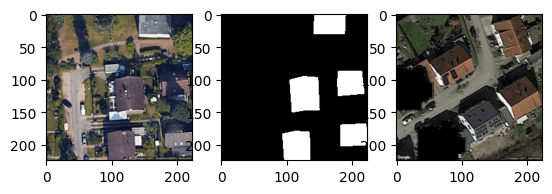

In [10]:
fig, axs = plt.subplots(1, 3)
axs[0].imshow(processed_train_images[0])
axs[1].imshow(processed_train_labels[0].squeeze(), cmap='gray')
axs[2].imshow(processed_test_images[0])
plt.show()

### Modelling


#### Base CNN Model

In [82]:
# Define the CNN model
input_shape = (224,224,3)
cnn = Sequential(name='CNN')

# Downsampling, Encoding 
cnn.add(Conv2D(32, (5, 5), activation='relu', input_shape=input_shape, padding='valid'))
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(Dropout(0.5))
cnn.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(Dropout(0.5))
cnn.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(Dropout(0.5))
cnn.add(Conv2D(256, (3, 3), activation='relu', padding='same'))

# Upsampling, Decoding
cnn.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), activation='relu', padding='same'))
cnn.add(Dropout(0.5))
cnn.add(Conv2DTranspose(64, (4, 4), strides=(2, 2), activation='relu', padding='same'))
cnn.add(Dropout(0.5))
cnn.add(Conv2DTranspose(32, (4, 4), strides=(2, 2), activation='relu', padding='same'))
cnn.add(Dropout(0.5))
cnn.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
cnn.add(Dropout(0.5))
cnn.add(Conv2D(1, (3, 3), activation='sigmoid', padding='same'))
cnn.add(ZeroPadding2D(padding=((4, 4), (4, 4))))

# Compile the model
cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = cnn.fit(processed_train_images, processed_train_labels, epochs=15, batch_size=5)


Epoch 1/15
4/4 [==============================] - 3s 72ms/step - loss: 0.7319 - accuracy: 0.7662
Epoch 2/15
4/4 [==============================] - 0s 56ms/step - loss: 0.5785 - accuracy: 0.8465
Epoch 3/15
4/4 [==============================] - 0s 53ms/step - loss: 0.6504 - accuracy: 0.8513
Epoch 4/15
4/4 [==============================] - 0s 53ms/step - loss: 0.6467 - accuracy: 0.8542
Epoch 5/15
4/4 [==============================] - 0s 53ms/step - loss: 0.6220 - accuracy: 0.8539
Epoch 6/15
4/4 [==============================] - 0s 55ms/step - loss: 0.5437 - accuracy: 0.8535
Epoch 7/15
4/4 [==============================] - 0s 54ms/step - loss: 0.5326 - accuracy: 0.8548
Epoch 8/15
4/4 [==============================] - 0s 53ms/step - loss: 0.5032 - accuracy: 0.8554
Epoch 9/15
4/4 [==============================] - 0s 54ms/step - loss: 0.5054 - accuracy: 0.8556
Epoch 10/15
4/4 [==============================] - 0s 53ms/step - loss: 0.4863 - accuracy: 0.8557
Epoch 11/15
4/4 [============

In [83]:
model_info(cnn)

Layer Type           Layer Name  \
0   <keras.layers.convolutional.conv2d.Conv2D obje...            conv2d_53   
1   <keras.layers.pooling.max_pooling2d.MaxPooling...     max_pooling2d_14   
2   <keras.layers.regularization.dropout.Dropout o...           dropout_14   
3   <keras.layers.convolutional.conv2d.Conv2D obje...            conv2d_54   
4   <keras.layers.pooling.max_pooling2d.MaxPooling...     max_pooling2d_15   
5   <keras.layers.regularization.dropout.Dropout o...           dropout_15   
6   <keras.layers.convolutional.conv2d.Conv2D obje...            conv2d_55   
7   <keras.layers.pooling.max_pooling2d.MaxPooling...     max_pooling2d_16   
8   <keras.layers.regularization.dropout.Dropout o...           dropout_16   
9   <keras.layers.convolutional.conv2d.Conv2D obje...            conv2d_56   
10  <keras.layers.convolutional.conv2d_transpose.C...  conv2d_transpose_19   
11  <keras.layers.regularization.dropout.Dropout o...           dropout_17   
12  <keras.layers.convolutional.conv2d_transpose.C...  conv2d_transpose_20   
13  <keras.layers.regularization.dropout.Dropout o...           dropout_18   
14  <keras.layers.convolutional.conv2d_transpose.C...  conv2d_transpose_21   
15  <keras.layers.regularization.dropout.Dropout o...           dropout_19   
16  <keras.layers.convolutional.conv2d.Conv2D obje...            conv2d_57   
17  <keras.layers.regularization.dropout.Dropout o...           dropout_20   
18  <keras.layers.convolutional.conv2d.Conv2D obje...            conv2d_58   
19  <keras.layers.reshaping.zero_padding2d.ZeroPad...     zero_padding2d_2   

    Layer Trainable              Layer Op  
0              True  (None, 220, 220, 32)  
1              True  (None, 110, 110, 32)  
2              True  (None, 110, 110, 32)  
3              True  (None, 110, 110, 64)  
4              True    (None, 55, 55, 64)  
5              True    (None, 55, 55, 64)  
6              True   (None, 55, 55, 128)  
7              True   (None, 27, 27, 128)  
8              True   (None, 27, 27, 128)  
9              True   (None, 27, 27, 256)  
10             True   (None, 54, 54, 128)  
11             True   (None, 54, 54, 128)  
12             True  (None, 108, 108, 64)  
13             True  (None, 108, 108, 64)  
14             True  (None, 216, 216, 32)  
15             True  (None, 216, 216, 32)  
16             True  (None, 216, 216, 64)  
17             True  (None, 216, 216, 64)  
18             True   (None, 216, 216, 1)  
19             True   (None, 224, 224, 1)

1/1 [==============================] - 0s 184ms/step


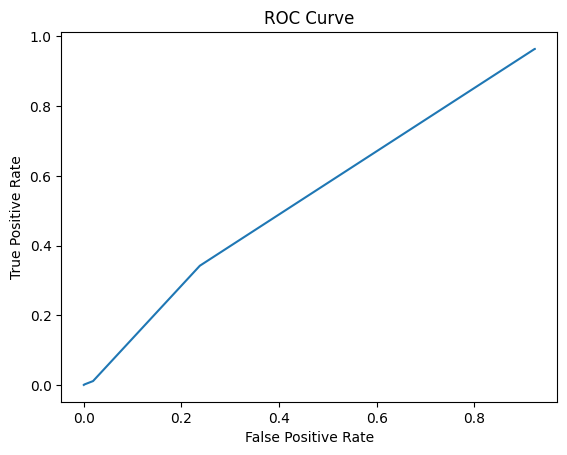

In [84]:
tprs,fprs = roc_curve(cnn)

1/1 [==============================] - 0s 20ms/step


Predictions for best threshold value: 0.30000000000000004


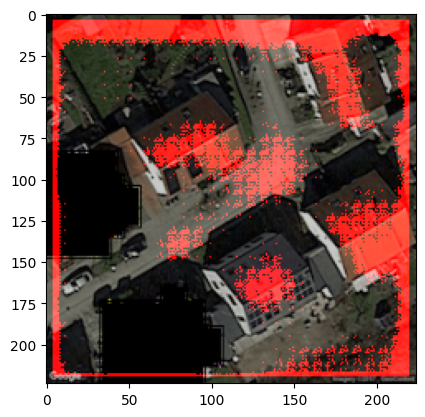

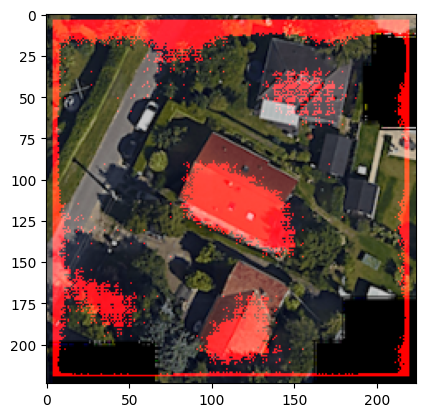

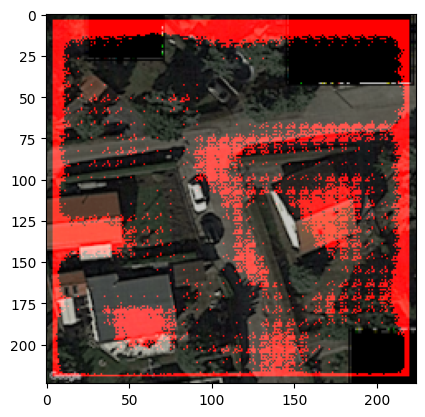

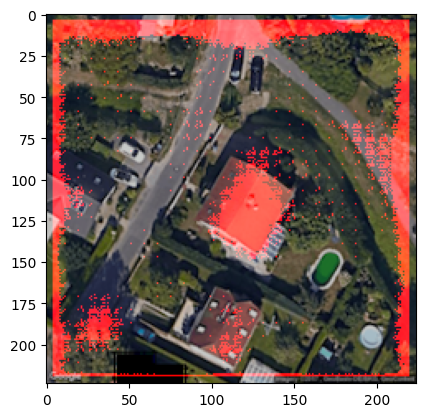

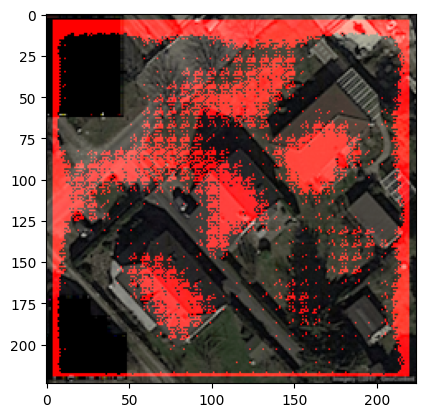

In [85]:
test_predictions(cnn,tprs,fprs)

### UNET

In [86]:
def EncoderMiniBlock(inputs, n_filters=32, dropout_prob=0.3, max_pooling=True):
  conv = Conv2D(n_filters, 
                3,  # filter size
                activation='relu',
                padding='same',
                kernel_initializer='HeNormal')(inputs)
  conv = Conv2D(n_filters, 
                3,  # filter size
                activation='relu',
                padding='same',
                kernel_initializer='HeNormal')(conv)

  conv = BatchNormalization()(conv, training=False)
  if dropout_prob > 0:     
      conv = tf.keras.layers.Dropout(dropout_prob)(conv)
  if max_pooling:
      next_layer = tf.keras.layers.MaxPooling2D(pool_size = (2,2))(conv)    
  else:
      next_layer = conv
  
  skip_connection = conv    
  return next_layer, skip_connection

In [87]:
def DecoderMiniBlock(prev_layer_input, skip_layer_input, n_filters=32):
  up = Conv2DTranspose(
                n_filters,
                (3,3),
                strides=(2,2),
                padding='same')(prev_layer_input)
  merge = concatenate([up, skip_layer_input],axis = 3)
  conv = Conv2D(n_filters, 
                3,  
                activation='relu',
                padding='same',
                kernel_initializer='HeNormal')(merge)
  conv = Conv2D(n_filters,
                3, 
                activation='relu',
                padding='same',
                kernel_initializer='HeNormal')(conv)
  return conv

In [88]:
def UNet(input_size=(224, 224, 3), n_filters=16, n_classes=1,dropout_prob = 0):
  """
  Combine both encoder and decoder blocks according to the U-Net research paper
  Return the model as output 
  """
  # Input size represent the size of 1 image (the size used for pre-processing)
  inputs = Input(input_size)

  # Encoder includes multiple convolutional mini blocks with different maxpooling, dropout and filter parameters
  # Observe that the filters are increasing as we go deeper into the network which will increasse the # channels of the image 
  # keeping dropout to be 0 becaue we have small dataset itself
  cblock1 = EncoderMiniBlock(inputs, n_filters,dropout_prob=0, max_pooling=True)
  cblock2 = EncoderMiniBlock(cblock1[0],n_filters*2,dropout_prob=0, max_pooling=True)
  cblock3 = EncoderMiniBlock(cblock2[0], n_filters*4,dropout_prob=0, max_pooling=True)
  cblock4 = EncoderMiniBlock(cblock3[0], n_filters*8,dropout_prob=dropout_prob, max_pooling=True)
  cblock5 = EncoderMiniBlock(cblock4[0], n_filters*16, dropout_prob=dropout_prob, max_pooling=False) 

  # Decoder includes multiple mini blocks with decreasing number of filters
  # Observe the skip connections from the encoder are given as input to the decoder
  # Recall the 2nd output of encoder block was skip connection, hence cblockn[1] is used
  ublock6 = DecoderMiniBlock(cblock5[0], cblock4[1],  n_filters * 8)
  ublock7 = DecoderMiniBlock(ublock6, cblock3[1],  n_filters * 4)
  ublock8 = DecoderMiniBlock(ublock7, cblock2[1],  n_filters * 2)
  ublock9 = DecoderMiniBlock(ublock8, cblock1[1],  n_filters)

  # Complete the model with 1 3x3 convolution layer (Same as the prev Conv Layers)
  # Followed by a 1x1 Conv layer to get the image to the desired size. 
  # Observe the number of channels will be equal to number of output classes
  conv9 = Conv2D(n_filters,
                3,
                activation='relu',
                padding='same',
                kernel_initializer='he_normal')(ublock9)

  conv10 = Conv2D(n_classes, 1, padding='same')(conv9)

  # Define the model
  model = Model(inputs=inputs, outputs=conv10,name = 'UNET')

  return model

In [89]:
unet = UNet()

In [90]:
model_info(unet)

Layer Type              Layer Name  \
0   <keras.engine.input_layer.InputLayer object at...                 input_5   
1   <keras.layers.convolutional.conv2d.Conv2D obje...               conv2d_59   
2   <keras.layers.convolutional.conv2d.Conv2D obje...               conv2d_60   
3   <keras.layers.normalization.batch_normalizatio...  batch_normalization_14   
4   <keras.layers.pooling.max_pooling2d.MaxPooling...        max_pooling2d_17   
5   <keras.layers.convolutional.conv2d.Conv2D obje...               conv2d_61   
6   <keras.layers.convolutional.conv2d.Conv2D obje...               conv2d_62   
7   <keras.layers.normalization.batch_normalizatio...  batch_normalization_15   
8   <keras.layers.pooling.max_pooling2d.MaxPooling...        max_pooling2d_18   
9   <keras.layers.convolutional.conv2d.Conv2D obje...               conv2d_63   
10  <keras.layers.convolutional.conv2d.Conv2D obje...               conv2d_64   
11  <keras.layers.normalization.batch_normalizatio...  batch_normalization_16   
12  <keras.layers.pooling.max_pooling2d.MaxPooling...        max_pooling2d_19   
13  <keras.layers.convolutional.conv2d.Conv2D obje...               conv2d_65   
14  <keras.layers.convolutional.conv2d.Conv2D obje...               conv2d_66   
15  <keras.layers.normalization.batch_normalizatio...  batch_normalization_17   
16  <keras.layers.pooling.max_pooling2d.MaxPooling...        max_pooling2d_20   
17  <keras.layers.convolutional.conv2d.Conv2D obje...               conv2d_67   
18  <keras.layers.convolutional.conv2d.Conv2D obje...               conv2d_68   
19  <keras.layers.normalization.batch_normalizatio...  batch_normalization_18   
20  <keras.layers.convolutional.conv2d_transpose.C...     conv2d_transpose_22   
21  <keras.layers.merging.concatenate.Concatenate ...          concatenate_12   
22  <keras.layers.convolutional.conv2d.Conv2D obje...               conv2d_69   
23  <keras.layers.convolutional.conv2d.Conv2D obje...               conv2d_70   
24  <keras.layers.convolutional.conv2d_transpose.C...     conv2d_transpose_23   
25  <keras.layers.merging.concatenate.Concatenate ...          concatenate_13   
26  <keras.layers.convolutional.conv2d.Conv2D obje...               conv2d_71   
27  <keras.layers.convolutional.conv2d.Conv2D obje...               conv2d_72   
28  <keras.layers.convolutional.conv2d_transpose.C...     conv2d_transpose_24   
29  <keras.layers.merging.concatenate.Concatenate ...          concatenate_14   
30  <keras.layers.convolutional.conv2d.Conv2D obje...               conv2d_73   
31  <keras.layers.convolutional.conv2d.Conv2D obje...               conv2d_74   
32  <keras.layers.convolutional.conv2d_transpose.C...     conv2d_transpose_25   
33  <keras.layers.merging.concatenate.Concatenate ...          concatenate_15   
34  <keras.layers.convolutional.conv2d.Conv2D obje...               conv2d_75   
35  <keras.layers.convolutional.conv2d.Conv2D obje...               conv2d_76   
36  <keras.layers.convolutional.conv2d.Conv2D obje...               conv2d_77   
37  <keras.layers.convolutional.conv2d.Conv2D obje...               conv2d_78   

    Layer Trainable              Layer Op  
0              True   (None, 224, 224, 3)  
1              True  (None, 224, 224, 16)  
2              True  (None, 224, 224, 16)  
3              True  (None, 224, 224, 16)  
4              True  (None, 112, 112, 16)  
5              True  (None, 112, 112, 32)  
6              True  (None, 112, 112, 32)  
7              True  (None, 112, 112, 32)  
8              True    (None, 56, 56, 32)  
9              True    (None, 56, 56, 64)  
10             True    (None, 56, 56, 64)  
11             True    (None, 56, 56, 64)  
12             True    (None, 28, 28, 64)  
13             True   (None, 28, 28, 128)  
14             True   (None, 28, 28, 128)  
15             True   (None, 28, 28, 128)  
16             True   (None, 14, 14, 128)  
17             True   (None, 14, 14, 256)  
18             True   (None, 14, 14, 256)  
19 

In [91]:
unet.compile(optimizer=Adam(),loss= 'binary_crossentropy', metrics=['accuracy'])
results = unet.fit(processed_train_images,processed_train_labels, batch_size=5, epochs=20, validation_data=(processed_val_images,processed_val_labels))

Epoch 1/20
4/4 [==============================] - 10s 200ms/step - loss: 2.2023 - accuracy: 0.8493 - val_loss: 2.2058 - val_accuracy: 0.8489
Epoch 2/20
4/4 [==============================] - 0s 64ms/step - loss: 1.9738 - accuracy: 0.8485 - val_loss: 1.9460 - val_accuracy: 0.8451
Epoch 3/20
4/4 [==============================] - 0s 53ms/step - loss: 1.7567 - accuracy: 0.8267 - val_loss: 1.4332 - val_accuracy: 0.8488
Epoch 4/20
4/4 [==============================] - 0s 53ms/step - loss: 0.9119 - accuracy: 0.8554 - val_loss: 0.4210 - val_accuracy: 0.8486
Epoch 5/20
4/4 [==============================] - 0s 54ms/step - loss: 0.4187 - accuracy: 0.8498 - val_loss: 0.4297 - val_accuracy: 0.8478
Epoch 6/20
4/4 [==============================] - 0s 56ms/step - loss: 0.4340 - accuracy: 0.8418 - val_loss: 0.4179 - val_accuracy: 0.8482
Epoch 7/20
4/4 [==============================] - 0s 58ms/step - loss: 0.4062 - accuracy: 0.8536 - val_loss: 0.4147 - val_accuracy: 0.8488
Epoch 8/20
4/4 [=========

1/1 [==============================] - 1s 734ms/step


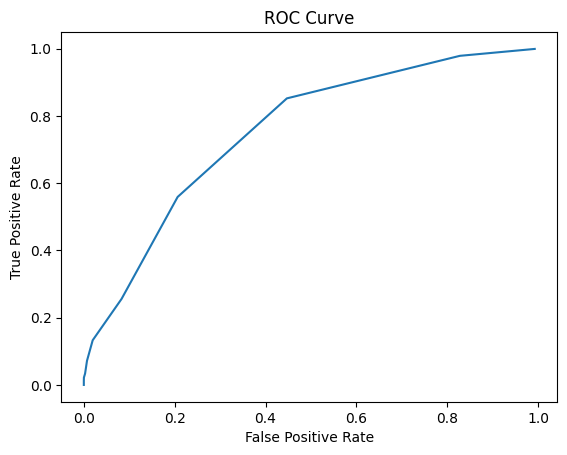

In [92]:
tprs,fprs = roc_curve(unet)

1/1 [==============================] - 0s 21ms/step


Predictions for best threshold value: 0.1


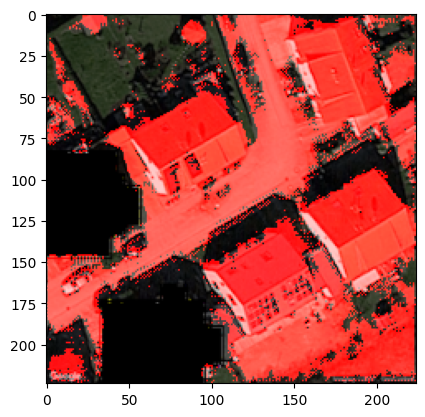

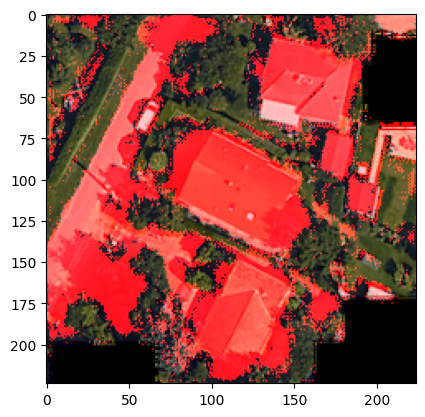

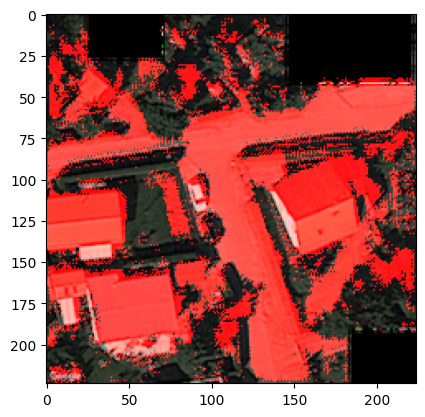

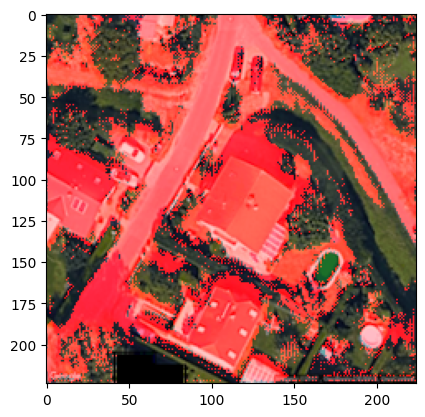

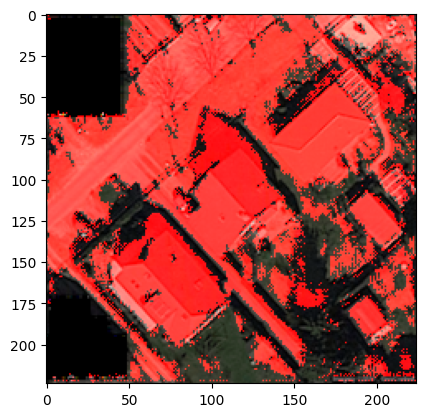

In [93]:
test_predictions(unet,tprs,fprs)

In [ ]:
# # Define the hyperparameter grid
# param_grid = {
#     'n_filters': [16, 32],
#     'dropout_prob': [0.1, 0.2, 0.3],
#     'batch_size': [3, 5, 10],
#     'epochs': [10, 15,20],
#     'learning_rate':[0.001, 0.01]
# }

# # Define the model function for use with KerasRegressor
# def create_model(n_filters=16, dropout_prob=0, input_size=(224, 224, 3)):
#     model = UNetCompiled(input_size=input_size, n_filters=n_filters, dropout_prob=dropout_prob)
#     model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#     return model

# # Wrap the model function with KerasRegressor
# keras_model = KerasRegressor(build_fn=create_model, verbose=0)

# # Define the GridSearchCV object with the hyperparameter grid and the wrapped Keras model
# grid_search = GridSearchCV(estimator=keras_model, param_grid=param_grid, n_jobs=-1)

# # Perform the search
# grid_result = grid_search.fit(processed_train_images,processed_train_labels, validation_data=(processed_val_images,processed_val_labels))

# # Print the best hyperparameters and corresponding score
# print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")

### Fine Tuned VGG16 combined with Unet

In [ ]:
VGG16 = vgg16.VGG16(include_top = False, weights = 'imagenet',input_shape = (224,224,3))

58889256/58889256 [==============================] - 3s 0us/step


In [ ]:
conv1 = ['block1_conv1','block1_conv2']
conv2 = ['block2_conv1','block2_conv2']
conv3 = ['block3_conv1','block3_conv2','block3_conv3']
conv4 = ['block4_conv1','block4_conv2','block4_conv3']
conv5 = ['block5_conv1','block5_conv2','block5_conv3']
pool1 = ['block1_pool']
pool2 = ['block2_pool']
pool3 = ['block3_pool']
pool4 = ['block4_pool']
pool5 = ['block5_pool']
train_layers = conv1 + conv2 + conv3 
non_train_layers = ['input_21']+pool1 + pool2 + pool3 + pool4 + pool5+conv4 + conv5

for layer in VGG16.layers:
  if layer.name in train_layers:
    layer.trainable = True
  if layer.name in non_train_layers:
    layer.trainable = False

layers = [(layer, layer.name, layer.trainable,layer.output.shape) for layer in VGG16.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable', 'Layer Op'])

Layer Type    Layer Name  \
0   <keras.engine.input_layer.InputLayer object at...       input_2   
1   <keras.layers.convolutional.conv2d.Conv2D obje...  block1_conv1   
2   <keras.layers.convolutional.conv2d.Conv2D obje...  block1_conv2   
3   <keras.layers.pooling.max_pooling2d.MaxPooling...   block1_pool   
4   <keras.layers.convolutional.conv2d.Conv2D obje...  block2_conv1   
5   <keras.layers.convolutional.conv2d.Conv2D obje...  block2_conv2   
6   <keras.layers.pooling.max_pooling2d.MaxPooling...   block2_pool   
7   <keras.layers.convolutional.conv2d.Conv2D obje...  block3_conv1   
8   <keras.layers.convolutional.conv2d.Conv2D obje...  block3_conv2   
9   <keras.layers.convolutional.conv2d.Conv2D obje...  block3_conv3   
10  <keras.layers.pooling.max_pooling2d.MaxPooling...   block3_pool   
11  <keras.layers.convolutional.conv2d.Conv2D obje...  block4_conv1   
12  <keras.layers.convolutional.conv2d.Conv2D obje...  block4_conv2   
13  <keras.layers.convolutional.conv2d.Conv2D obje...  block4_conv3   
14  <keras.layers.pooling.max_pooling2d.MaxPooling...   block4_pool   
15  <keras.layers.convolutional.conv2d.Conv2D obje...  block5_conv1   
16  <keras.layers.convolutional.conv2d.Conv2D obje...  block5_conv2   
17  <keras.layers.convolutional.conv2d.Conv2D obje...  block5_conv3   
18  <keras.layers.pooling.max_pooling2d.MaxPooling...   block5_pool   

    Layer Trainable               Layer Op  
0              True    (None, 224, 224, 3)  
1              True   (None, 224, 224, 64)  
2              True   (None, 224, 224, 64)  
3             False   (None, 112, 112, 64)  
4              True  (None, 112, 112, 128)  
5              True  (None, 112, 112, 128)  
6             False    (None, 56, 56, 128)  
7              True    (None, 56, 56, 256)  
8              True    (None, 56, 56, 256)  
9              True    (None, 56, 56, 256)  
10            False    (None, 28, 28, 256)  
11            False    (None, 28, 28, 512)  
12            False    (None, 28, 28, 512)  
13            False    (None, 28, 28, 512)  
14            False    (None, 14, 14, 512)  
15            False    (None, 14, 14, 512)  
16            False    (None, 14, 14, 512)  
17            False    (None, 14, 14, 512)  
18            False      (None, 7, 7, 512)

In [ ]:
from tensorflow.keras.layers import LeakyReLU
def DecoderMiniBlock(prev_layer_input, skip_layer_input, n_filters=32):
  up = Conv2DTranspose(n_filters, (3, 3), 
                       strides=(2, 2),
                       padding='same',
                       activation=LeakyReLU(0.1), 
                       kernel_initializer='he_normal')(prev_layer_input)
  up = BatchNormalization()(up)
  merge = concatenate([up, skip_layer_input],axis = 3)
  conv = Conv2D(n_filters, 
                3,  
                activation='relu',
                padding='same',
                kernel_initializer='HeNormal')(merge)
  # conv = Conv2D(n_filters,
  #               3, 
  #               activation='relu',
  #               padding='same',
  #               kernel_initializer='HeNormal')(conv)
  return conv

In [ ]:
def Vgg_Unet(input_size=(224, 224, 3), n_filters=16, n_classes=1,dropout_prob = 0):
  VGG16 = vgg16.VGG16(include_top = False, weights = 'imagenet',input_shape = input_size)
  last_layer = VGG16.output

  set_trainable = False

  train_layers = list(conv1[0])
  non_train_layers = pool1 + pool2 + pool3 + pool4 + pool5 

  for layer in VGG16.layers:
    if layer.name in train_layers:
      layer.trainable = True
    if layer.name in non_train_layers:
      layer.trainable = False
  
  
  last_layer = VGG16.output
  unet = DecoderMiniBlock(last_layer,VGG16.get_layer("block5_conv3").output, 512)
  unet = DecoderMiniBlock(unet,VGG16.get_layer("block4_conv3").output, 512)
  unet = DecoderMiniBlock(unet,VGG16.get_layer("block3_conv3").output, 256)
  unet = DecoderMiniBlock(unet,VGG16.get_layer("block2_conv2").output, 128)
  unet = DecoderMiniBlock(unet,VGG16.get_layer("block1_conv2").output, 64)

  conv9 = Conv2D(32,
                3,
                activation='relu',
                padding='same',
                kernel_initializer='he_normal')(unet)
  conv10 = Conv2D(16,
                3,
                activation='relu',
                padding='same',
                kernel_initializer='he_normal')(conv9)

  conv11 = Conv2D(n_classes,
                1,
                activation='relu',
                padding='same',
                kernel_initializer='he_normal')(unet)

  model = Model(VGG16.input,conv11)
  return model

In [ ]:
unet_vgg = Vgg_Unet()

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(unet_vgg, to_file='UNET with VGG16.png', show_shapes=True, rankdir='TB')
layers = [(layer, layer.name, layer.trainable,layer.output.shape) for layer in unet.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable', 'Layer Op'])

Layer Type             Layer Name  \
0   <keras.engine.input_layer.InputLayer object at...                input_1   
1   <keras.layers.convolutional.conv2d.Conv2D obje...               conv2d_6   
2   <keras.layers.convolutional.conv2d.Conv2D obje...               conv2d_7   
3   <keras.layers.normalization.batch_normalizatio...    batch_normalization   
4   <keras.layers.pooling.max_pooling2d.MaxPooling...        max_pooling2d_3   
5   <keras.layers.convolutional.conv2d.Conv2D obje...               conv2d_8   
6   <keras.layers.convolutional.conv2d.Conv2D obje...               conv2d_9   
7   <keras.layers.normalization.batch_normalizatio...  batch_normalization_1   
8   <keras.layers.pooling.max_pooling2d.MaxPooling...        max_pooling2d_4   
9   <keras.layers.convolutional.conv2d.Conv2D obje...              conv2d_10   
10  <keras.layers.convolutional.conv2d.Conv2D obje...              conv2d_11   
11  <keras.layers.normalization.batch_normalizatio...  batch_normalization_2   
12  <keras.layers.pooling.max_pooling2d.MaxPooling...        max_pooling2d_5   
13  <keras.layers.convolutional.conv2d.Conv2D obje...              conv2d_12   
14  <keras.layers.convolutional.conv2d.Conv2D obje...              conv2d_13   
15  <keras.layers.normalization.batch_normalizatio...  batch_normalization_3   
16  <keras.layers.pooling.max_pooling2d.MaxPooling...        max_pooling2d_6   
17  <keras.layers.convolutional.conv2d.Conv2D obje...              conv2d_14   
18  <keras.layers.convolutional.conv2d.Conv2D obje...              conv2d_15   
19  <keras.layers.normalization.batch_normalizatio...  batch_normalization_4   
20  <keras.layers.convolutional.conv2d_transpose.C...     conv2d_transpose_3   
21  <keras.layers.merging.concatenate.Concatenate ...            concatenate   
22  <keras.layers.convolutional.conv2d.Conv2D obje...              conv2d_16   
23  <keras.layers.convolutional.conv2d.Conv2D obje...              conv2d_17   
24  <keras.layers.convolutional.conv2d_transpose.C...     conv2d_transpose_4   
25  <keras.layers.merging.concatenate.Concatenate ...          concatenate_1   
26  <keras.layers.convolutional.conv2d.Conv2D obje...              conv2d_18   
27  <keras.layers.convolutional.conv2d.Conv2D obje...              conv2d_19   
28  <keras.layers.convolutional.conv2d_transpose.C...     conv2d_transpose_5   
29  <keras.layers.merging.concatenate.Concatenate ...          concatenate_2   
30  <keras.layers.convolutional.conv2d.Conv2D obje...              conv2d_20   
31  <keras.layers.convolutional.conv2d.Conv2D obje...              conv2d_21   
32  <keras.layers.convolutional.conv2d_transpose.C...     conv2d_transpose_6   
33  <keras.layers.merging.concatenate.Concatenate ...          concatenate_3   
34  <keras.layers.convolutional.conv2d.Conv2D obje...              conv2d_22   
35  <keras.layers.convolutional.conv2d.Conv2D obje...              conv2d_23   
36  <keras.layers.convolutional.conv2d.Conv2D obje...              conv2d_24   
37  <keras.layers.convolutional.conv2d.Conv2D obje...              conv2d_25   

    Layer Trainable              Layer Op  
0              True   (None, 224, 224, 3)  
1              True  (None, 224, 224, 16)  
2              True  (None, 224, 224, 16)  
3              True  (None, 224, 224, 16)  
4              True  (None, 112, 112, 16)  
5              True  (None, 112, 112, 32)  
6              True  (None, 112, 112, 32)  
7              True  (None, 112, 112, 32)  
8              True    (None, 56, 56, 32)  
9              True    (None, 56, 56, 64)  
10             True    (None, 56, 56, 64)  
11             True    (None, 56, 56, 64)  
12             True    (None, 28, 28, 64)  
13             True   (None, 28, 28, 128)  
14             True   (None, 28, 28, 128)  
15             True   (None, 28, 28, 128)  
16             True   (None, 14, 14, 128)  
17             True   (None, 14, 14, 256)  
18             True   (None, 14, 14, 256)  
19             True   (None, 14, 14, 256) 

In [ ]:
unet_vgg.compile(optimizer = Adam(),loss = 'binary_crossentropy',metrics = ['accuracy'])
results = unet_vgg.fit(processed_train_images,processed_train_labels,batch_size = 5, epochs = 20, validation_data = (processed_val_images,processed_val_labels))

Epoch 1/20
4/4 [==============================] - 21s 379ms/step - loss: 4.9330 - accuracy: 0.6676 - val_loss: 3.3029 - val_accuracy: 0.7737
Epoch 2/20
4/4 [==============================] - 1s 297ms/step - loss: 2.2247 - accuracy: 0.8558 - val_loss: 2.3308 - val_accuracy: 0.8489
Epoch 3/20
4/4 [==============================] - 1s 261ms/step - loss: 2.2247 - accuracy: 0.8558 - val_loss: 2.3308 - val_accuracy: 0.8489
Epoch 4/20
4/4 [==============================] - 1s 259ms/step - loss: 2.2247 - accuracy: 0.8558 - val_loss: 2.3308 - val_accuracy: 0.8489
Epoch 5/20
4/4 [==============================] - 1s 261ms/step - loss: 2.2247 - accuracy: 0.8558 - val_loss: 2.3308 - val_accuracy: 0.8489
Epoch 6/20
4/4 [==============================] - 1s 283ms/step - loss: 2.2247 - accuracy: 0.8558 - val_loss: 2.3308 - val_accuracy: 0.8489
Epoch 7/20
4/4 [==============================] - 1s 291ms/step - loss: 2.2247 - accuracy: 0.8558 - val_loss: 2.3308 - val_accuracy: 0.8489
Epoch 8/20
4/4 [===

1/1 [==============================] - 0s 278ms/step
(5, 224, 224, 1)


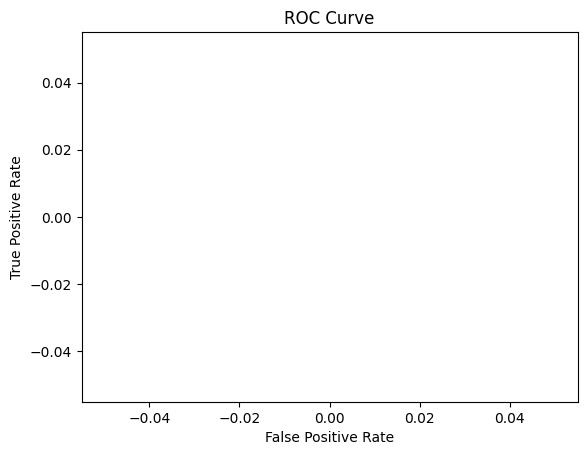

In [ ]:
from sklearn.metrics import confusion_matrix

predicted_images = unet_vgg.predict(processed_val_images)
print(predicted_images.shape)
# Threshold the predicted images using different threshold values
thresholds = np.arange(0, 1.05, 0.05) # check all thresholds from 0-1 in 0.05 interval
tprs = []
fprs = []

for threshold in thresholds:
    # apply threshold and convert to binary images
    
    binary_images = (predicted_images > threshold).astype('uint8')
    binary_images = np.reshape(binary_images, (-1, 224, 224, 1))
    
    # calculate confusion matrix
    cm = confusion_matrix(processed_val_labels.flatten(), binary_images.flatten())
    tn, fp, fn, tp = cm.ravel()
    
    # calculate TPR and FPR
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    
    tprs.append(tpr)
    fprs.append(fpr)

# plot the ROC curve
plt.plot(fprs, tprs)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [ ]:
from scipy.spatial.distance import euclidean

# calculate distance to top left corner for each point on the ROC curve
distances = [euclidean([0, 1], [fprs[i], tprs[i]]) for i in range(len(fprs))]

# find index of point with smallest distance
best_index = np.argmin(distances)

# get corresponding threshold value
best_threshold = thresholds[best_index]

print(f'Best threshold: {best_threshold:.2f}')

Best threshold: 0.00


1/1 [==============================] - 0s 38ms/step


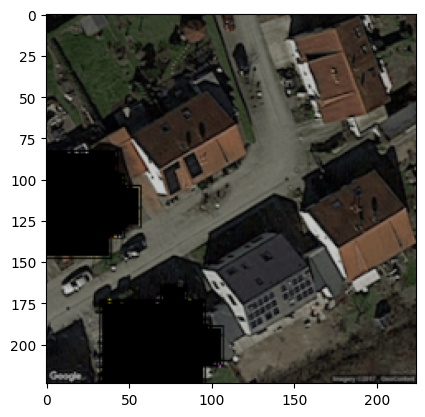

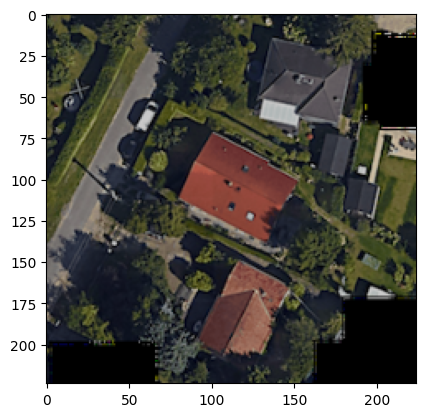

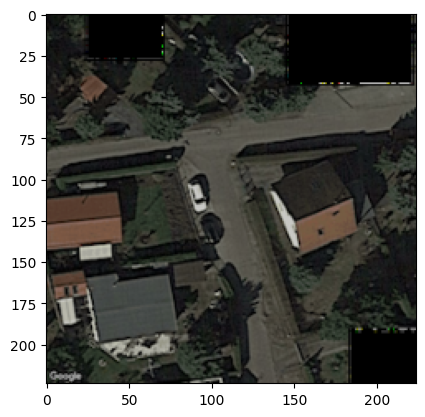

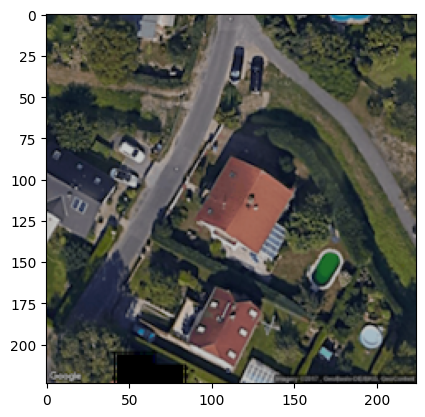

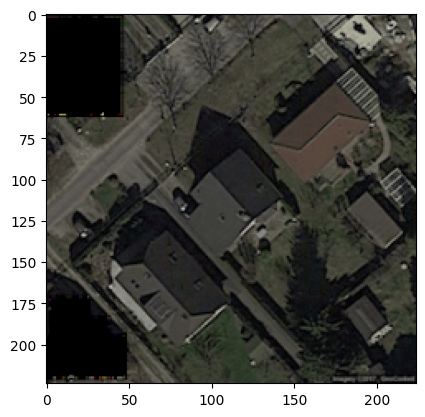

In [ ]:
threshold = best_threshold # set threshold value
predicted_images = unet_vgg.predict(test_images) # predict on test images

# apply threshold and convert to binary images
binary_images = (predicted_images > threshold).astype('uint8')
binary_images = np.reshape(binary_images, (-1, 224, 224, 1))
# highlight rooftops in binary images
for i in range(binary_images.shape[0]):
    test_image = test_images[i]
    test_image = cv2.resize(test_image, (224, 224), interpolation=cv2.INTER_LINEAR)
    binary_image = binary_images[i].squeeze()
    rooftop_image = np.zeros_like(test_image)
    rooftop_image[:,:,0] = binary_image*255 # set red channel to binary image
    final_image = cv2.addWeighted(test_image, 0.8, rooftop_image, 0.2, 0) # blend images
    plt.imshow(final_image)
    plt.show()

### Unet with MobileNet


In [57]:
!apt remove git -y
!apt-get install git -y && git clone https://github.com/tensorflow/examples.git

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages were automatically installed and are no longer required:
  git-man liberror-perl
Use 'apt autoremove' to remove them.
The following packages will be REMOVED:
  git git-lfs
0 upgraded, 0 newly installed, 2 to remove and 24 not upgraded.
After this operation, 47.9 MB disk space will be freed.
(Reading database ... 122518 files and directories currently installed.)
Removing git-lfs (2.9.2-1) ...
Removing git (1:2.25.1-1ubuntu3.11) ...
Processing triggers for man-db (2.9.1-1) ...
Reading package lists... Done
Building dependency tree       
Reading state information... Done
Suggested packages:
  gettext-base git-daemon-run | git-daemon-sysvinit git-doc git-el git-email
  git-gui gitk gitweb git-cvs git-mediawiki git-svn
The following NEW packages will be installed:
  git
0 upgraded, 1 newly installed, 0 to remove and 24 not upgraded.
Need to get 4,605 kB of archives.
After

In [94]:
from examples.tensorflow_examples.models.pix2pix import pix2pix

In [95]:
base_model = MobileNetV2(input_shape=[224, 224, 3], include_top=False)

##################

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)
down_stack.trainable = False

##################

up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

##################


def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[224, 224, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # Append another Conv2DTranspose layer with appropriate parameters
  x = tf.keras.layers.Conv2DTranspose(
      filters=64, kernel_size=3, strides=2,
      padding='same')(x)

  x = tf.keras.layers.Conv2D(
      filters=1, kernel_size=1, strides=1,
      padding='valid')(x)
    
  # x = tf.keras.layers.Cropping2D(cropping=96)(x)
    
  x = tf.keras.activations.sigmoid(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

# build the model
unet_mob = unet_model(output_channels=1)

unet_mob.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

unet_mob(processed_train_images).shape

TensorShape([20, 224, 224, 1])

In [97]:
from tensorflow.keras.utils import plot_model
plot_model(unet_mob, to_file='UNET_Mob.png', show_shapes=True, rankdir='TB')
layers = [(layer, layer.name, layer.trainable,layer.output) for layer in unet_mob.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable', 'Layer Op'])

Layer Type           Layer Name  \
0   <keras.engine.input_layer.InputLayer object at...              input_7   
1   <keras.engine.functional.Functional object at ...              model_3   
2   <keras.engine.sequential.Sequential object at ...         sequential_5   
3   <keras.layers.merging.concatenate.Concatenate ...       concatenate_16   
4   <keras.engine.sequential.Sequential object at ...         sequential_6   
5   <keras.layers.merging.concatenate.Concatenate ...       concatenate_17   
6   <keras.engine.sequential.Sequential object at ...         sequential_7   
7   <keras.layers.merging.concatenate.Concatenate ...       concatenate_18   
8   <keras.engine.sequential.Sequential object at ...         sequential_8   
9   <keras.layers.merging.concatenate.Concatenate ...       concatenate_19   
10  <keras.layers.convolutional.conv2d_transpose.C...  conv2d_transpose_30   
11  <keras.layers.convolutional.conv2d.Conv2D obje...            conv2d_79   
12  <keras.layers.core.tf_op_layer.TFOpLambda obje...    tf.math.sigmoid_1   

    Layer Trainable                                           Layer Op  
0              True  KerasTensor(type_spec=TensorSpec(shape=(None, ...  
1             False  [KerasTensor(type_spec=TensorSpec(shape=(None,...  
2              True  KerasTensor(type_spec=TensorSpec(shape=(None, ...  
3              True  KerasTensor(type_spec=TensorSpec(shape=(None, ...  
4              True  KerasTensor(type_spec=TensorSpec(shape=(None, ...  
5              True  KerasTensor(type_spec=TensorSpec(shape=(None, ...  
6              True  KerasTensor(type_spec=TensorSpec(shape=(None, ...  
7              True  KerasTensor(type_spec=TensorSpec(shape=(None, ...  
8              True  KerasTensor(type_spec=TensorSpec(shape=(None, ...  
9              True  KerasTensor(type_spec=TensorSpec(shape=(None, ...  
10             True  KerasTensor(type_spec=TensorSpec(shape=(None, ...  
11             True  KerasTensor(type_spec=TensorSpec(shape=(None, ...  
12             True  KerasTensor(type_spec=TensorSpec(shape=(None, ...

In [98]:
unet_mob.fit(
    processed_train_images, 
    processed_train_labels,
    epochs=20,
    batch_size=3,
    validation_data=(processed_val_images, processed_val_labels)
)

Epoch 1/20
7/7 [==============================] - 8s 291ms/step - loss: 0.6709 - accuracy: 0.7979 - val_loss: 0.6178 - val_accuracy: 0.8101
Epoch 2/20
7/7 [==============================] - 0s 65ms/step - loss: 0.3973 - accuracy: 0.8580 - val_loss: 0.4098 - val_accuracy: 0.8543
Epoch 3/20
7/7 [==============================] - 1s 86ms/step - loss: 0.2368 - accuracy: 0.9193 - val_loss: 0.5329 - val_accuracy: 0.8496
Epoch 4/20
7/7 [==============================] - 1s 99ms/step - loss: 0.1599 - accuracy: 0.9391 - val_loss: 0.5976 - val_accuracy: 0.8563
Epoch 5/20
7/7 [==============================] - 1s 97ms/step - loss: 0.1298 - accuracy: 0.9517 - val_loss: 0.7003 - val_accuracy: 0.8359
Epoch 6/20
7/7 [==============================] - 1s 98ms/step - loss: 0.1025 - accuracy: 0.9622 - val_loss: 0.6918 - val_accuracy: 0.8496
Epoch 7/20
7/7 [==============================] - 0s 61ms/step - loss: 0.0850 - accuracy: 0.9685 - val_loss: 0.7233 - val_accuracy: 0.8590
Epoch 8/20
7/7 [==========

1/1 [==============================] - 0s 28ms/step


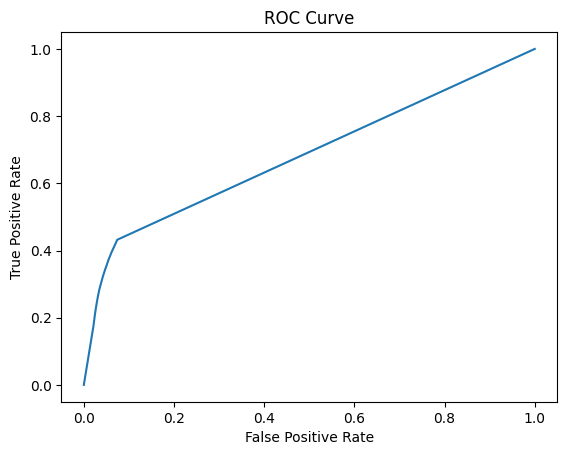

In [101]:
tprs, fprs = roc_curve(unet_mob)

1/1 [==============================] - 0s 27ms/step


Predictions for best threshold value: 0.1


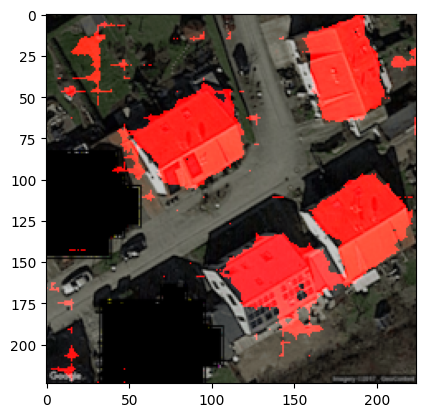

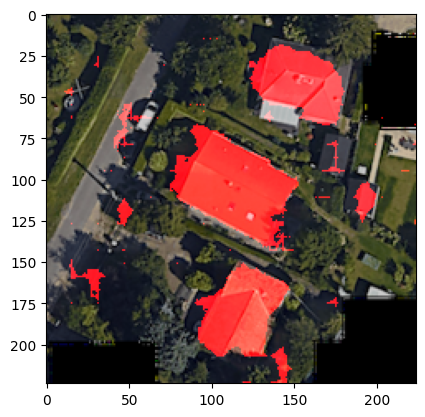

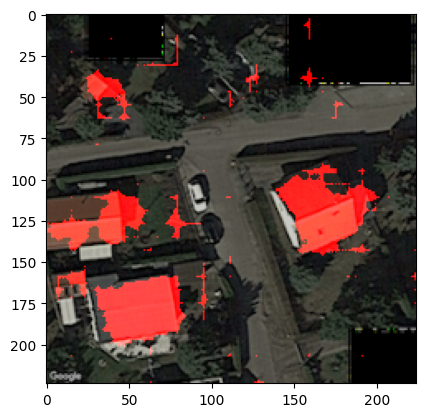

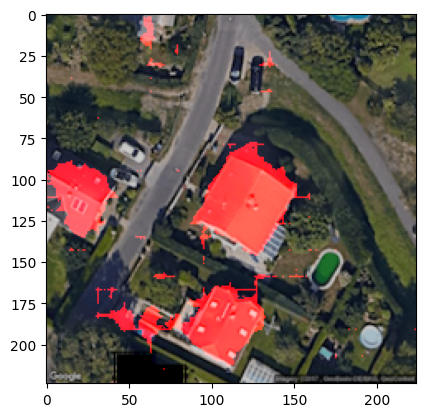

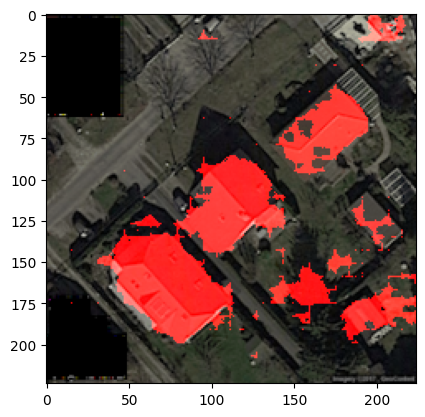

In [100]:
test_predictions(unet_mob,tprs,fprs)

## Image Augmentation

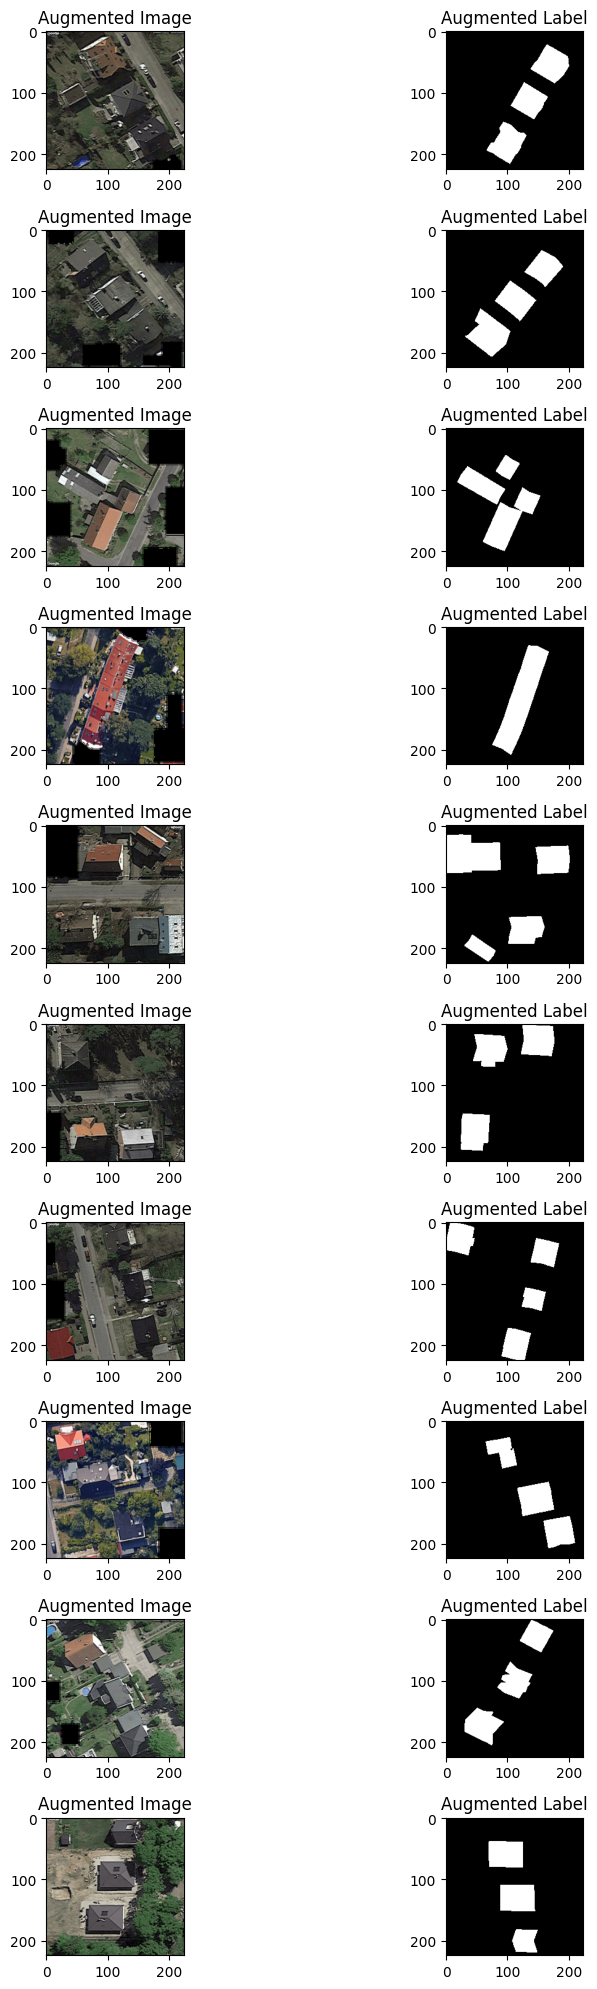

In [ ]:
import matplotlib.pyplot as plt

# create generator for training data with data augmentation
train_datagen = ImageDataGenerator(
        #rescale=1./255,
        #rotation_range=20,
        #width_shift_range=0.2,
        #height_shift_range=0.2,
        #shear_range=0.2,
        #zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip = True,
        fill_mode='nearest')

# create generator for training data
train_generator = train_datagen.flow(
        processed_train_images, 
        processed_train_labels, 
        batch_size=10)

# get one batch of augmented images and labels
aug_images, aug_labels = train_generator.next()

# plot the augmented images and labels
fig, axs = plt.subplots(10, 2, figsize=(10, 20))
for i in range(10):
    axs[i, 0].imshow(aug_images[i])
    axs[i, 0].set_title('Augmented Image')
    axs[i, 1].imshow(aug_labels[i,:,:,0], cmap='gray')
    axs[i, 1].set_title('Augmented Label')
fig.tight_layout()
plt.show()
